In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

### Simulating signal

#### Model: 

$y(k)=\sum_{r}A_r\sin\left(2\pi f\left[t_0+\dfrac{k}{F}-\dfrac{r}{f_m}\right]\right)\cdot e^{-\beta(L)\left(t_0 + \frac{k}{F}-\frac{r}{f_m}\right)}\cdot u\left(t_0+\dfrac{k}{F}-\dfrac{r}{f_m}\right)$

In [56]:
df=pd.read_csv("data/L030_TI_High_VEL020_fs1000.csv")
t = df['t [s]'].to_numpy()
N=len(t)
fs=1e3
r=0.46

1.922161148452842


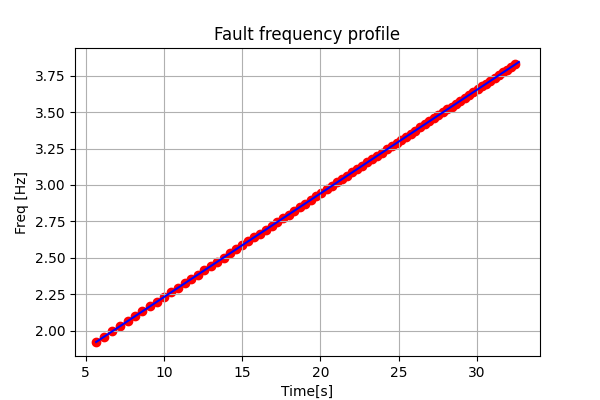

In [63]:
Ar= 1   #Amplitude
f = 55    #Resonant Frequency in Hz
b=50      #Exponential decay factor

n=np.arange(N)

#fr_var=curve_rayleigh(t)
v_var=1e3*np.linspace(20,40,N) # km/h
#v_var=20e3*np.ones((N,))

fr_var=v_var/(3600*2*np.pi*r)
print(np.min(fr_var))

f_fail=fr_var.copy()
ω_fail=2*np.pi*f_fail
θr_fail=np.cumsum(ω_fail)/fs

t_indexes=[]
t_impact=[]
N_of_impacts=np.int32(np.floor(np.max(θr_fail)/(2*np.pi)))+1
for i in range(N_of_impacts):
    t_index=np.argmin(np.abs(θr_fail-i*2*np.pi))
    t_indexes.append(t_index)
    t_impact.append(t[t_index])
    #print(i,t_index,t[t_index])

impacts=(np.array(t_indexes),np.array(t_impact))

plt.close('all')
%matplotlib widget
plt.figure(figsize=(6,4)) ### change tuple for better visualization or change inline for qt in %matplotlib inline 
plt.plot(t,f_fail,color='blue')
plt.title('Fault frequency profile')
plt.xlabel('Time[s]')
plt.ylabel('Freq [Hz]')
plt.grid()
plt.scatter(impacts[1],f_fail[impacts[0]],color='red',marker='o')
plt.show()

In [64]:
def conditional_exp(t, b):
    result = np.zeros_like(t, dtype=float)
    positive_indices = t > 0
    result[positive_indices] = np.exp(-b * t[positive_indices])
    return result

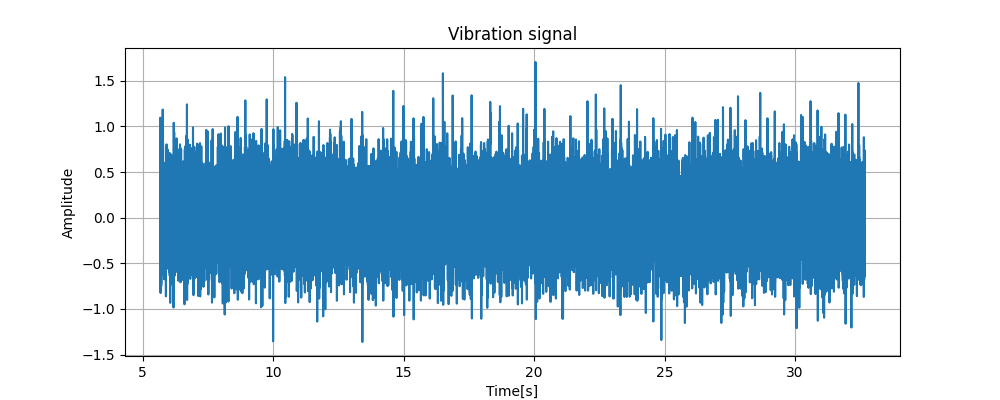

In [98]:
Sx_var=np.zeros((N,))

for t_i in range(len(t_impact)):
    time_diff=t[0]+n/fs-t_impact[t_i]
    Sx_var+=Ar*np.sin(2*np.pi*f*(time_diff))*conditional_exp(time_diff, b)*np.heaviside(time_diff, 1)

desired_noise_power = 1e-1
#Sx_var=Sx_var-np.mean(Sx_var)
Sx_var=Sx_var + np.random.normal(loc=0.0, scale=np.sqrt(desired_noise_power), size=Sx_var.shape)

plt.close('all')
%matplotlib widget
plt.figure(figsize=(10, 4))
plt.plot(t,Sx_var)
plt.grid(True)
plt.title('Vibration signal')
plt.xlabel('Time[s]')
plt.ylabel('Amplitude')
plt.show()

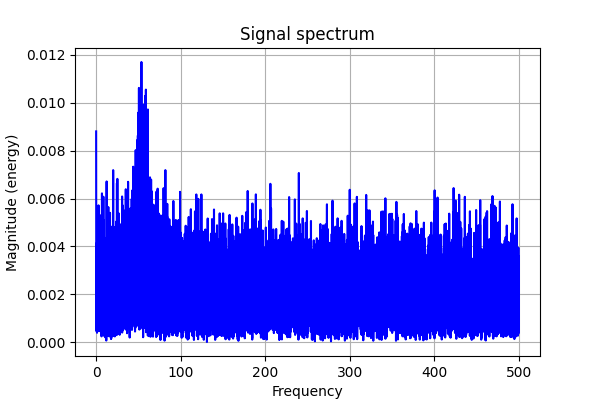

In [99]:
plt.close('all')
%matplotlib widget
plt.figure(figsize=(6,4))
spectrum=plt.magnitude_spectrum(Sx_var, Fs=fs, color='blue')
plt.title("Signal spectrum")
plt.grid(True)
plt.show()


In [100]:
Λ=10
D_lambda=1/16
K=int(Λ/D_lambda)
Ts=1/fs
λs=np.arange(0,Λ,D_lambda)
print('K:',K)
print(len(f_fail))
print(Ts)

K: 160
27001
0.001


In [101]:
G=np.zeros((K,N),dtype=np.complex128)
for k in range(K):
    G[k,:]=np.exp(-1j*2*np.pi*D_lambda*k*Ts*np.cumsum(f_fail))

print('G dim:',G.shape)


Sx_var_env=np.abs(signal.hilbert(Sx_var))

Sx_var_env=Sx_var_env-np.mean(Sx_var_env)

Sx_env_analytic=signal.hilbert(Sx_var_env)

X_lambda = (1/N)*np.dot(G, Sx_env_analytic)

G dim: (160, 27001)


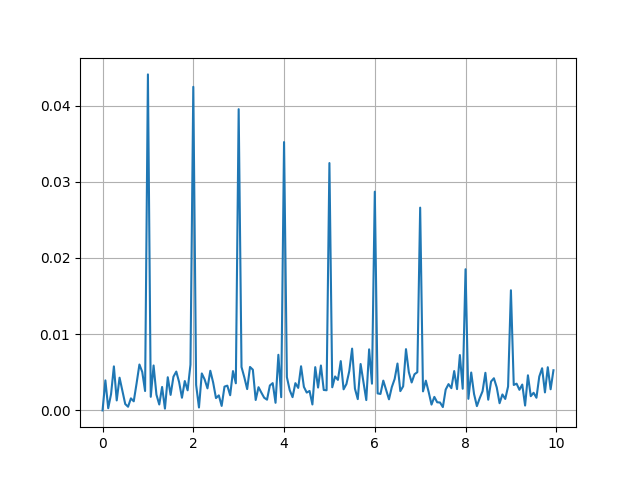

In [102]:
plt.close('all')
%matplotlib widget

plt.plot(λs,np.abs(X_lambda))
plt.grid(True)